In [1]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.keras as iso

from aparent.losses.aparent_losses import *

from visualization.seqprop_visualization import *
from generator.seqprop_generator import *
from predictor.seqprop_predictor import *
from predictor.definitions.aparent_large_all_libs import load_saved_predictor
from optimizer.seqprop_optimizer import *


Using TensorFlow backend.


In [2]:

#Define target cleavage loss function
def get_cleavage_loss(cut_pos, punish_up_c=False, punish_dn_cse=False, punish_dn_aruns=False, reward_dn_ggcc=False) :
    
    target_cuts = np.zeros((1, 1, 206))
    target_cuts[:, :, cut_pos] = 1.0
    
    target_entropy_mse = get_target_entropy_mse(pwm_start=25, pwm_end=125, target_bits=1.8)
    
    punish_up_c_func = get_punish_c(pwm_start=25, pwm_end=68)
    punish_dn_cse_func = get_punish_cse(pwm_start=74, pwm_end=125)
    reward_dn_ggcc_func = get_reward_ggcc(pwm_start=76, pwm_end=125)
    punish_dn_aa_func = get_punish_aa(pwm_start=76, pwm_end=125)

    def loss_func(predictor_outputs) :
        pwm_logits, pwm, sampled_pwm, iso_pred, cut_pred, iso_score_pred, cut_score_pred = predictor_outputs

        #Create target cut constant
        cut_true = K.tile(K.constant(target_cuts), (K.shape(sampled_pwm)[0], K.shape(sampled_pwm)[1], 1))

        #Specify costs
        cut_loss = 1.0 * K.mean(kl_divergence(cut_true, cut_pred), axis=0)
        seq_loss = 0.0
        
        if punish_up_c :
            seq_loss += 0.025 * K.mean(punish_up_c_func(sampled_pwm), axis=0)
        
        if punish_dn_cse :
            seq_loss += 1.0 * K.mean(punish_dn_cse_func(sampled_pwm), axis=0)
        
        if reward_dn_ggcc :
            seq_loss += 0.05 * K.mean(reward_dn_ggcc_func(sampled_pwm), axis=0)
        
        if punish_dn_aruns :
            seq_loss += 0.25 * K.mean(punish_dn_aa_func(sampled_pwm), axis=0)
        
        entropy_loss = 0.25 * target_entropy_mse(pwm)
        
        #Compute total loss
        total_loss = cut_loss + seq_loss + entropy_loss

        return K.sum(total_loss, axis=0)
    
    return loss_func


#Function for running SeqProp on a set of objectives to optimize
def run_seqprop(sequence_templates, target_cuts, loss_funcs, n_sequences=1, n_samples=1, n_epochs=10, steps_per_epoch=100) :
    
    n_objectives = len(sequence_templates)
    
    optimized_pwms = []
    optimized_cuts = []
    
    for obj_ix in range(n_objectives) :
        print("Optimizing objective " + str(obj_ix) + '...')
        
        sequence_template = sequence_templates[obj_ix]
        target_cut = target_cuts[obj_ix]
        loss_func = loss_funcs[obj_ix]
        
        #Build Generator Network
        _, seqprop_generator = build_generator(seq_length=205, n_sequences=n_sequences, n_samples=n_samples, sequence_templates=[sequence_template * n_sequences], batch_normalize_pwm=True)
        
        #Build Predictor Network and hook it on the generator PWM output tensor
        _, seqprop_predictor = build_predictor(seqprop_generator, load_saved_predictor(model_path, library_context='simple'), n_sequences=n_sequences, n_samples=n_samples, eval_mode='sample')
        
        #Build Loss Model (In: Generator seed, Out: Loss function)
        _, loss_model = build_loss_model(seqprop_predictor, loss_func)
        
        #Specify Optimizer to use
        #opt = keras.optimizers.SGD(lr=0.1)
        opt = keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999)

        #Compile Loss Model (Minimize self)
        loss_model.compile(loss=lambda true, pred: pred, optimizer=opt)

        #Specify callback entities
        callbacks =[
            EarlyStopping(monitor='loss', min_delta=0.001, patience=5, verbose=0, mode='auto'),
            SeqPropMonitor(predictor=seqprop_predictor, plot_every_epoch=False, track_every_step=True, isoform_start=target_cut, isoform_end=target_cut+1, pwm_start=70-40, pwm_end=76+50, sequence_template=sequence_template, plot_pwm_indices=[0])
        ]

        #Fit Loss Model
        train_history = loss_model.fit(
            [], np.ones((1, 1)), #Dummy training example
            epochs=n_epochs,
            steps_per_epoch=steps_per_epoch,
            callbacks=callbacks
        )
        
        #Retrieve optimized PWMs and predicted cleavage distributionns
        _, optimized_pwm, _, _, cut_pred, _, _ = seqprop_predictor.predict(x=None, steps=1)
        
        optimized_pwms.append(optimized_pwm)
        optimized_cuts.append(cut_pred)

    return optimized_pwms, optimized_cuts
        


In [3]:
#Specfiy file path to pre-trained predictor network

save_dir = os.path.join(os.getcwd(), '../aparent/saved_models')
model_name = 'aparent_large_all_libs.h5'
model_path = os.path.join(save_dir, model_name)

In [4]:
#Define standard sequence template

seq_template = 'XXXXXXXXXXXXXXXXXXXXXATCTNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNAATAAANNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNNGTGTCCTGCCCGGTCGGCTTGAGCGCGTGGGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG'

#Define list of target cleavage positions

cut_objectives = [81, 86, 91, 96, 101, 106, 111, 116, 121]


Running optimization experiment 'Vanilla'
Optimizing objective 0...


/home/johli/anaconda3/envs/aparent/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


Epoch 1/5
500/500 [==============================] - 17s 34ms/step - loss: 23.1086
Epoch 2/5
500/500 [==============================] - 16s 32ms/step - loss: 7.0764
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 4.6133
Epoch 4/5
500/500 [==============================] - 18s 36ms/step - loss: 3.7239
Epoch 5/5
500/500 [==============================] - 18s 36ms/step - loss: 3.2017


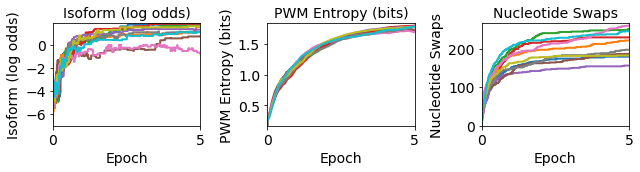

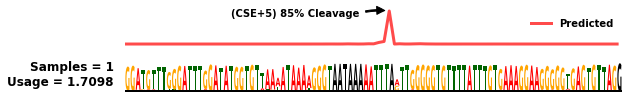

Optimizing objective 1...
Epoch 1/5
500/500 [==============================] - 18s 36ms/step - loss: 11.6036
Epoch 2/5
500/500 [==============================] - 17s 34ms/step - loss: 2.7098
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 1.6599
Epoch 4/5
500/500 [==============================] - 18s 35ms/step - loss: 1.2541
Epoch 5/5
500/500 [==============================] - 19s 37ms/step - loss: 1.1165


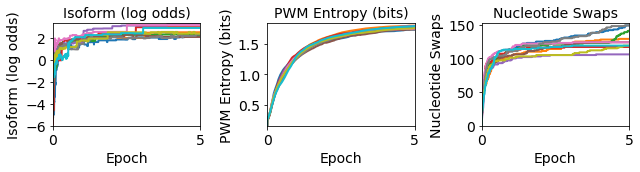

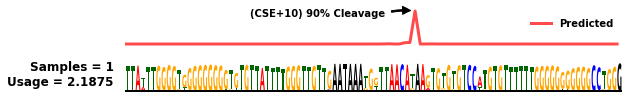

Optimizing objective 2...
Epoch 1/5
500/500 [==============================] - 18s 37ms/step - loss: 11.5901
Epoch 2/5
500/500 [==============================] - 19s 38ms/step - loss: 3.1843
Epoch 3/5
500/500 [==============================] - 25s 50ms/step - loss: 2.2227
Epoch 4/5
500/500 [==============================] - 25s 50ms/step - loss: 1.9544
Epoch 5/5
500/500 [==============================] - 20s 40ms/step - loss: 1.6513


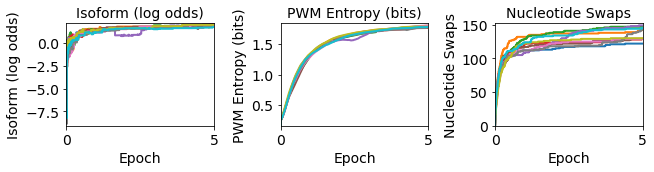

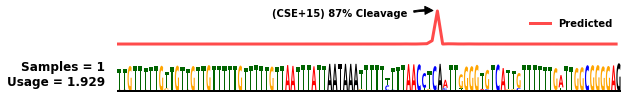

Optimizing objective 3...
Epoch 1/5
500/500 [==============================] - 20s 40ms/step - loss: 10.3289
Epoch 2/5
500/500 [==============================] - 18s 36ms/step - loss: 2.5870
Epoch 3/5
500/500 [==============================] - 17s 33ms/step - loss: 1.6820
Epoch 4/5
500/500 [==============================] - 15s 30ms/step - loss: 1.3098
Epoch 5/5
500/500 [==============================] - 18s 36ms/step - loss: 1.0893


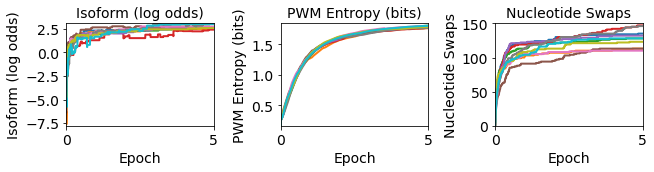

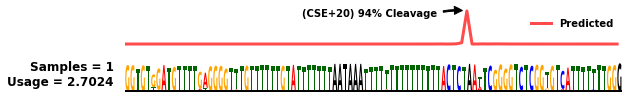

Optimizing objective 4...
Epoch 1/5
500/500 [==============================] - 20s 40ms/step - loss: 10.7610
Epoch 2/5
500/500 [==============================] - 18s 35ms/step - loss: 1.7727
Epoch 3/5
500/500 [==============================] - 18s 35ms/step - loss: 0.9640
Epoch 4/5
500/500 [==============================] - 15s 30ms/step - loss: 0.7609
Epoch 5/5
500/500 [==============================] - 14s 29ms/step - loss: 0.7060


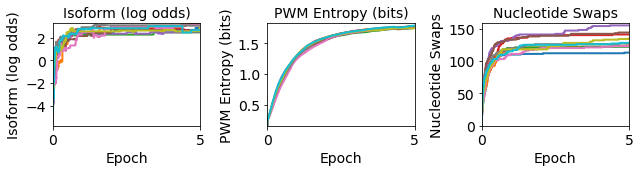

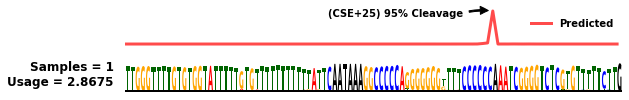

Optimizing objective 5...
Epoch 1/5
500/500 [==============================] - 17s 34ms/step - loss: 11.6867
Epoch 2/5
500/500 [==============================] - 14s 29ms/step - loss: 1.3828
Epoch 3/5
500/500 [==============================] - 14s 28ms/step - loss: 0.0038
Epoch 4/5
500/500 [==============================] - 14s 28ms/step - loss: -0.3445
Epoch 5/5
500/500 [==============================] - 15s 29ms/step - loss: -0.4902


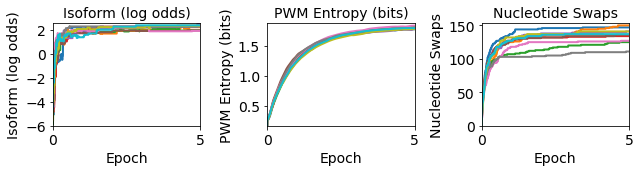

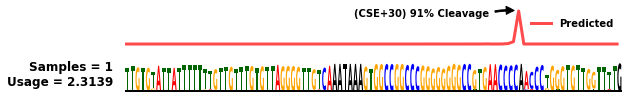

Optimizing objective 6...
Epoch 1/5
500/500 [==============================] - 17s 33ms/step - loss: 17.9521
Epoch 2/5
500/500 [==============================] - 16s 31ms/step - loss: 2.8543
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 0.5473
Epoch 4/5
500/500 [==============================] - 17s 34ms/step - loss: -0.1276
Epoch 5/5
500/500 [==============================] - 18s 36ms/step - loss: -0.4907


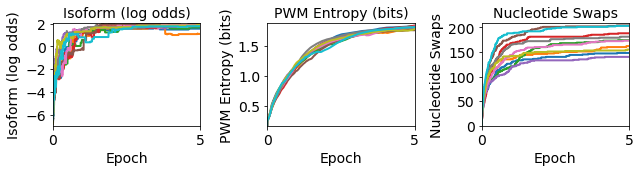

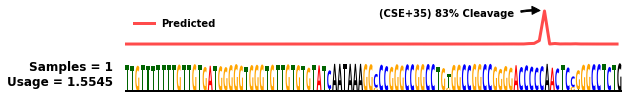

Optimizing objective 7...
Epoch 1/5
500/500 [==============================] - 17s 33ms/step - loss: 18.6342
Epoch 2/5
500/500 [==============================] - 16s 31ms/step - loss: 3.7354
Epoch 3/5
500/500 [==============================] - 14s 27ms/step - loss: 1.1862
Epoch 4/5
500/500 [==============================] - 14s 27ms/step - loss: 0.3828
Epoch 5/5
500/500 [==============================] - 18s 36ms/step - loss: -0.0698


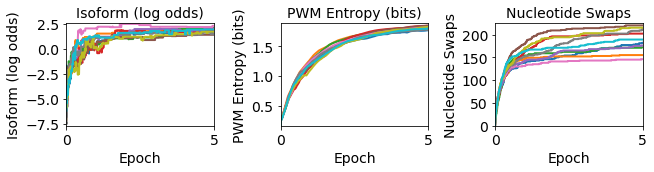

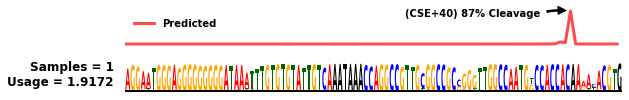

Optimizing objective 8...
Epoch 1/5
500/500 [==============================] - 17s 35ms/step - loss: 31.8627
Epoch 2/5
500/500 [==============================] - 15s 29ms/step - loss: 7.5965
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 4.1754
Epoch 4/5
500/500 [==============================] - 19s 38ms/step - loss: 3.1430
Epoch 5/5
500/500 [==============================] - 20s 40ms/step - loss: 2.8598


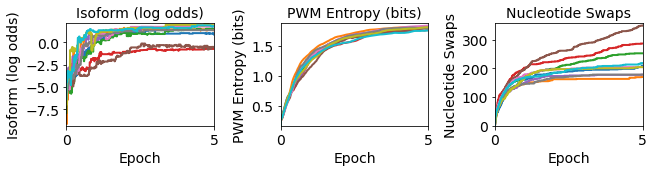

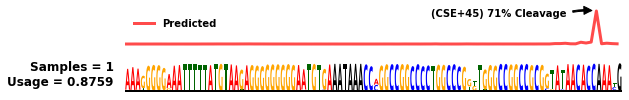

In [5]:
#Run SeqProp Optimization (experiment 'Vanilla')

print("Running optimization experiment 'Vanilla'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 5#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

sequence_templates = [
    seq_template[:cut_pos] + "A" + seq_template[cut_pos + 1:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        punish_up_c = True,
        punish_dn_cse = True,
        punish_dn_aruns = False,
        reward_dn_ggcc = False if cut_pos < 105 else True
    ) for cut_pos in cut_objectives
]

vanilla_pwms, vanilla_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


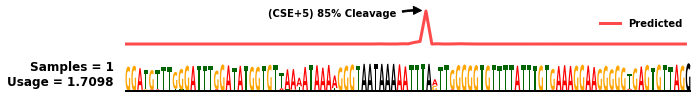

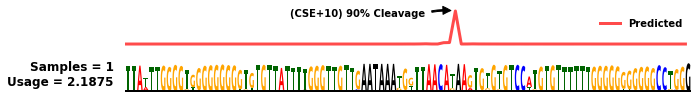

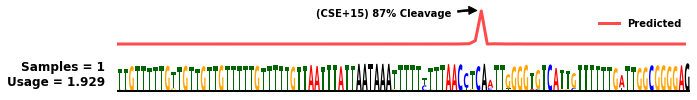

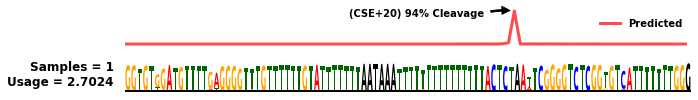

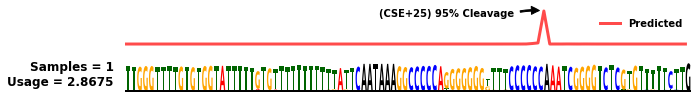

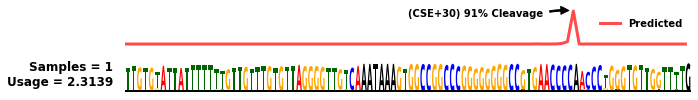

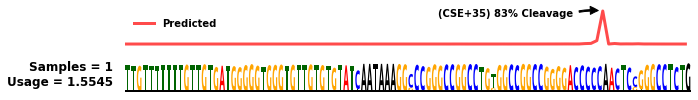

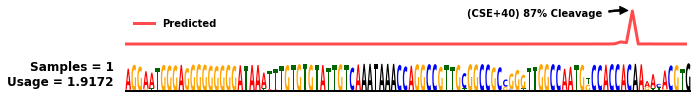

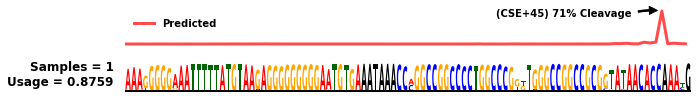

In [7]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Vanilla')

pwms = vanilla_pwms
cuts = vanilla_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=70-40, plot_end=76+50)


Running optimization experiment 'Punish A-runs'
Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 25s 49ms/step - loss: 25.7455
Epoch 2/5
500/500 [==============================] - 19s 37ms/step - loss: 9.4886
Epoch 3/5
500/500 [==============================] - 22s 44ms/step - loss: 6.7014
Epoch 4/5
500/500 [==============================] - 19s 38ms/step - loss: 5.7623
Epoch 5/5
500/500 [==============================] - 19s 38ms/step - loss: 5.2531


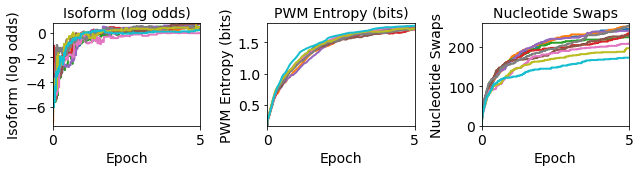

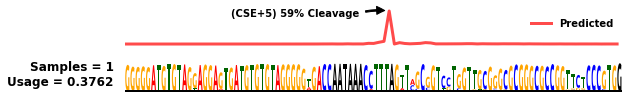

Optimizing objective 1...
Epoch 1/5
500/500 [==============================] - 24s 47ms/step - loss: 13.4648
Epoch 2/5
500/500 [==============================] - 19s 38ms/step - loss: 4.1202
Epoch 3/5
500/500 [==============================] - 23s 46ms/step - loss: 3.1296
Epoch 4/5
500/500 [==============================] - 19s 37ms/step - loss: 2.6454
Epoch 5/5
500/500 [==============================] - 25s 49ms/step - loss: 2.3100


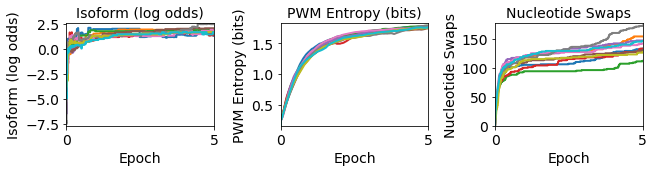

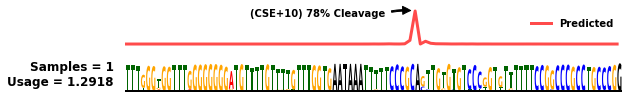

Optimizing objective 2...
Epoch 1/5
500/500 [==============================] - 21s 43ms/step - loss: 12.6495
Epoch 2/5
500/500 [==============================] - 15s 29ms/step - loss: 4.0190
Epoch 3/5
500/500 [==============================] - 18s 36ms/step - loss: 2.6851
Epoch 4/5
500/500 [==============================] - 16s 32ms/step - loss: 2.3385
Epoch 5/5
500/500 [==============================] - 17s 35ms/step - loss: 2.0549


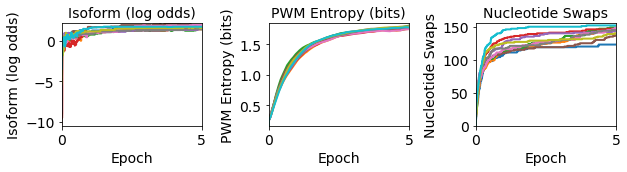

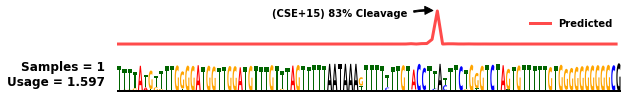

Optimizing objective 3...
Epoch 1/5
500/500 [==============================] - 21s 42ms/step - loss: 11.4722
Epoch 2/5
500/500 [==============================] - 18s 37ms/step - loss: 3.3607
Epoch 3/5
500/500 [==============================] - 21s 42ms/step - loss: 2.0963
Epoch 4/5
500/500 [==============================] - 21s 43ms/step - loss: 1.8512
Epoch 5/5
500/500 [==============================] - 23s 47ms/step - loss: 1.6084


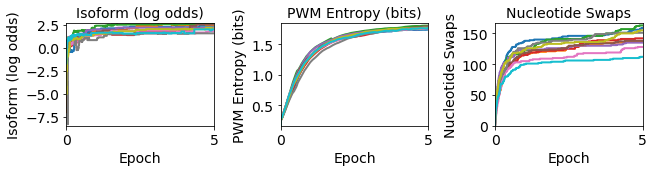

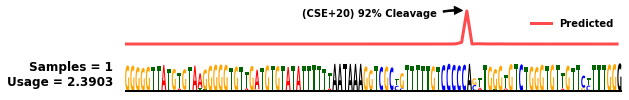

Optimizing objective 4...
Epoch 1/5
500/500 [==============================] - 26s 52ms/step - loss: 12.0064
Epoch 2/5
500/500 [==============================] - 23s 46ms/step - loss: 2.3815
Epoch 3/5
500/500 [==============================] - 18s 35ms/step - loss: 1.5905
Epoch 4/5
500/500 [==============================] - 21s 41ms/step - loss: 1.3334
Epoch 5/5
500/500 [==============================] - 17s 33ms/step - loss: 1.2458


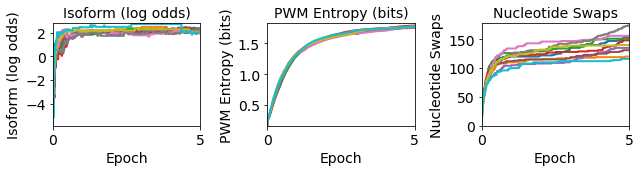

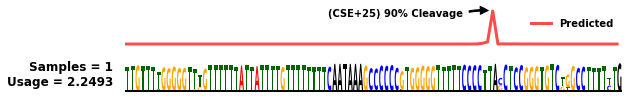

Optimizing objective 5...
Epoch 1/5
500/500 [==============================] - 21s 43ms/step - loss: 12.5244
Epoch 2/5
500/500 [==============================] - 20s 41ms/step - loss: 2.0033
Epoch 3/5
500/500 [==============================] - 18s 36ms/step - loss: 0.3905
Epoch 4/5
500/500 [==============================] - 20s 40ms/step - loss: -0.1470
Epoch 5/5
500/500 [==============================] - 20s 39ms/step - loss: -0.3748


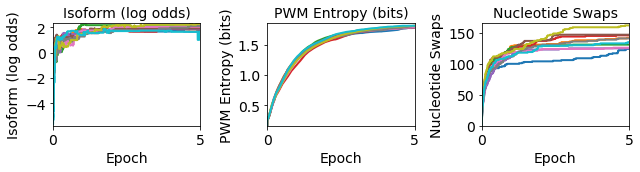

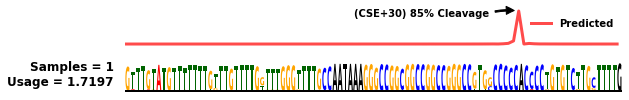

Optimizing objective 6...
Epoch 1/5
500/500 [==============================] - 20s 40ms/step - loss: 17.4926
Epoch 2/5
500/500 [==============================] - 14s 28ms/step - loss: 4.2832
Epoch 3/5
500/500 [==============================] - 17s 34ms/step - loss: 2.0347
Epoch 4/5
500/500 [==============================] - 16s 31ms/step - loss: 1.3277
Epoch 5/5
500/500 [==============================] - 16s 32ms/step - loss: 0.9610


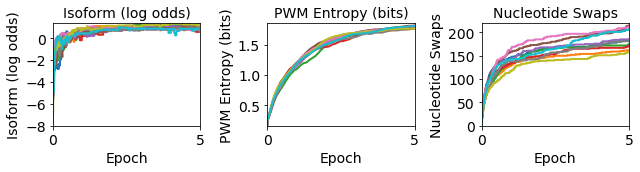

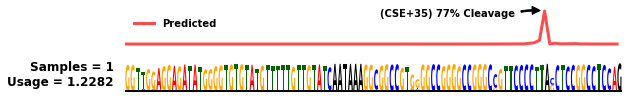

Optimizing objective 7...
Epoch 1/5
500/500 [==============================] - 20s 40ms/step - loss: 18.1612
Epoch 2/5
500/500 [==============================] - 14s 29ms/step - loss: 2.6311
Epoch 3/5
500/500 [==============================] - 14s 29ms/step - loss: 0.5347
Epoch 4/5
500/500 [==============================] - 19s 38ms/step - loss: -0.1424
Epoch 5/5
500/500 [==============================] - 14s 29ms/step - loss: -0.4739


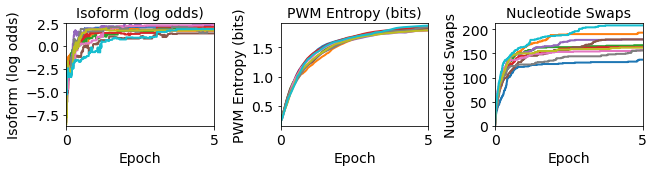

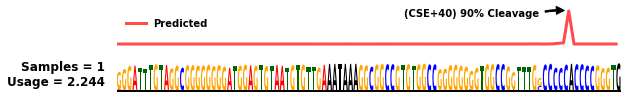

Optimizing objective 8...
Epoch 1/5
500/500 [==============================] - 23s 45ms/step - loss: 26.9718
Epoch 2/5
500/500 [==============================] - 16s 32ms/step - loss: 6.4147
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 4.0436
Epoch 4/5
500/500 [==============================] - 16s 32ms/step - loss: 3.3167
Epoch 5/5
500/500 [==============================] - 15s 31ms/step - loss: 2.8524


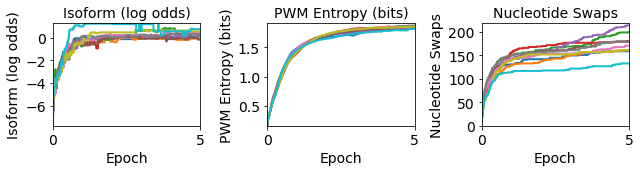

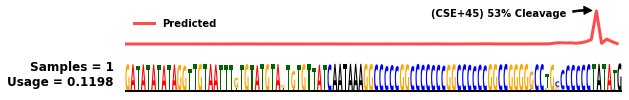

In [9]:
#Run SeqProp Optimization (experiment 'Punish A-runs')

print("Running optimization experiment 'Punish A-runs'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 5#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

sequence_templates = [
    seq_template[:cut_pos] + "A" + seq_template[cut_pos + 1:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        punish_up_c = True,
        punish_dn_cse = True,
        punish_dn_aruns = True,
        reward_dn_ggcc = False if cut_pos < 105 else True
    ) for cut_pos in cut_objectives
]

punish_aruns_pwms, punish_aruns_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


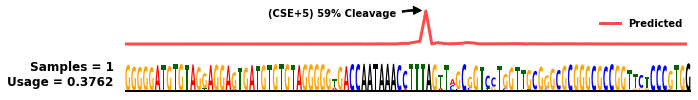

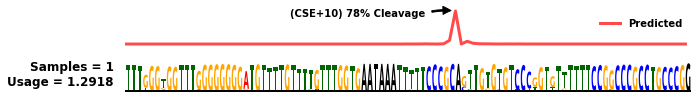

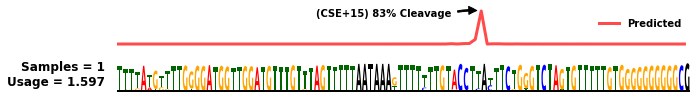

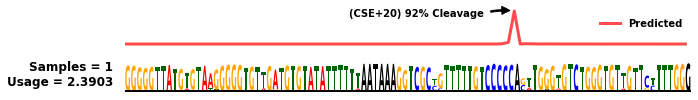

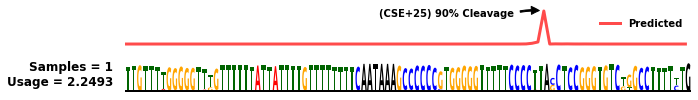

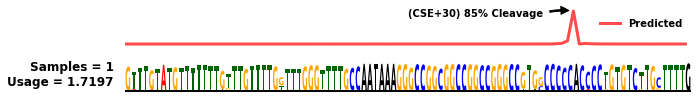

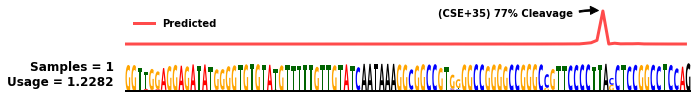

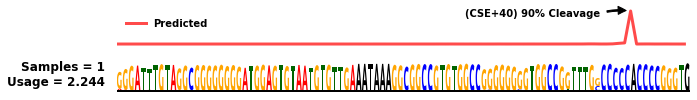

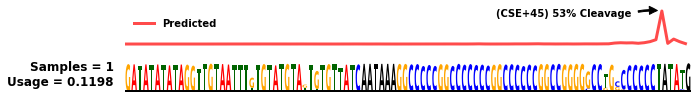

In [10]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Punish A-runs')

pwms = punish_aruns_pwms
cuts = punish_aruns_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=70-40, plot_end=76+50)


Running optimization experiment 'Hardcoded AT'
Optimizing objective 0...
Epoch 1/5
500/500 [==============================] - 24s 48ms/step - loss: 23.8846
Epoch 2/5
500/500 [==============================] - 19s 37ms/step - loss: 8.4529
Epoch 3/5
500/500 [==============================] - 16s 32ms/step - loss: 6.1114
Epoch 4/5
500/500 [==============================] - 17s 34ms/step - loss: 5.5895
Epoch 5/5
500/500 [==============================] - 16s 32ms/step - loss: 5.2314


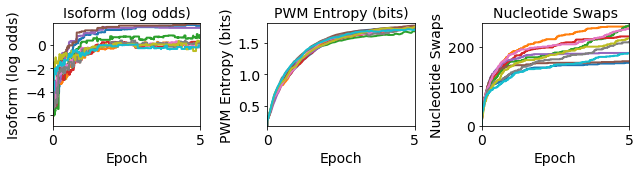

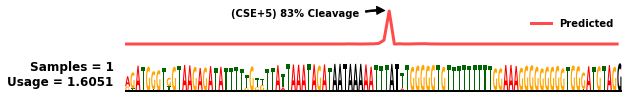

Optimizing objective 1...
Epoch 1/5
500/500 [==============================] - 21s 43ms/step - loss: 13.9358
Epoch 2/5
500/500 [==============================] - 17s 33ms/step - loss: 4.7503
Epoch 3/5
500/500 [==============================] - 17s 33ms/step - loss: 3.4357
Epoch 4/5
500/500 [==============================] - 17s 34ms/step - loss: 2.9038
Epoch 5/5
500/500 [==============================] - 17s 34ms/step - loss: 2.5654


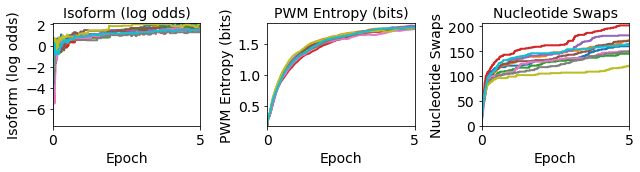

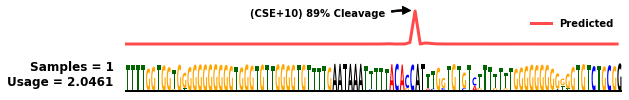

Optimizing objective 2...
Epoch 1/5
500/500 [==============================] - 25s 50ms/step - loss: 12.2620
Epoch 2/5
500/500 [==============================] - 18s 36ms/step - loss: 3.7870
Epoch 3/5
500/500 [==============================] - 16s 33ms/step - loss: 2.6724
Epoch 4/5
500/500 [==============================] - 20s 39ms/step - loss: 2.3326
Epoch 5/5
500/500 [==============================] - 17s 35ms/step - loss: 2.0550


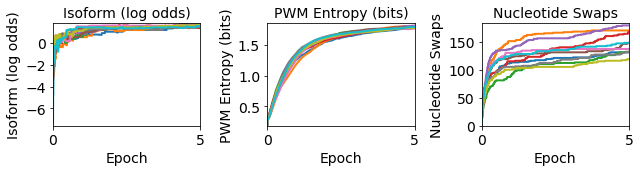

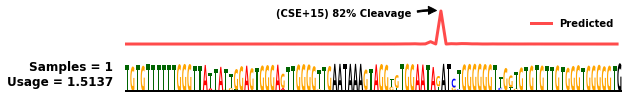

Optimizing objective 3...
Epoch 1/5
500/500 [==============================] - 23s 45ms/step - loss: 11.6933
Epoch 2/5
500/500 [==============================] - 18s 35ms/step - loss: 3.4966
Epoch 3/5
500/500 [==============================] - 17s 34ms/step - loss: 2.1161
Epoch 4/5
500/500 [==============================] - 17s 34ms/step - loss: 1.7885
Epoch 5/5
500/500 [==============================] - 18s 36ms/step - loss: 1.5889


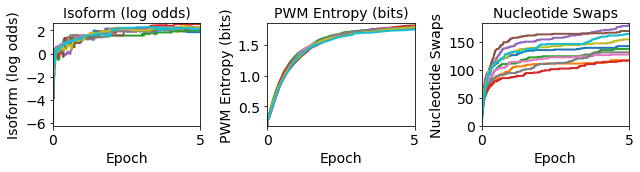

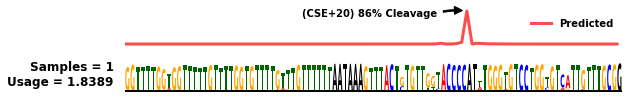

Optimizing objective 4...
Epoch 1/5
500/500 [==============================] - 48s 97ms/step - loss: 12.4409
Epoch 2/5
500/500 [==============================] - 37s 75ms/step - loss: 2.8415
Epoch 3/5
500/500 [==============================] - 31s 62ms/step - loss: 1.6601
Epoch 4/5
500/500 [==============================] - 37s 75ms/step - loss: 1.3157
Epoch 5/5
500/500 [==============================] - 33s 66ms/step - loss: 1.1566


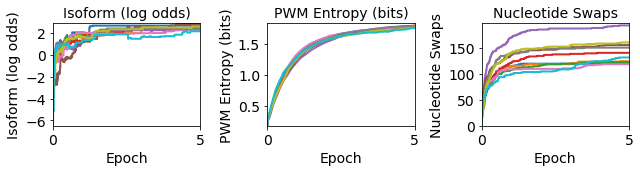

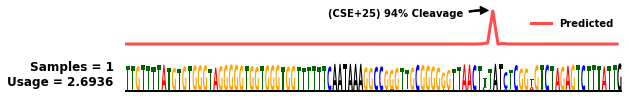

Optimizing objective 5...
Epoch 1/5
500/500 [==============================] - 48s 96ms/step - loss: 13.2299
Epoch 2/5
500/500 [==============================] - 38s 75ms/step - loss: 2.0655
Epoch 3/5
500/500 [==============================] - 22s 43ms/step - loss: 0.4476
Epoch 4/5
500/500 [==============================] - 16s 33ms/step - loss: 0.0727
Epoch 5/5
500/500 [==============================] - 16s 32ms/step - loss: -0.1343


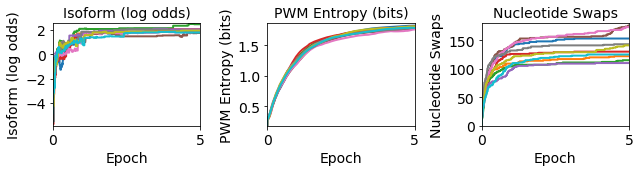

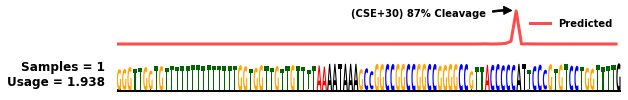

Optimizing objective 6...
Epoch 1/5
500/500 [==============================] - 29s 58ms/step - loss: 18.5728
Epoch 2/5
500/500 [==============================] - 34s 68ms/step - loss: 4.1193
Epoch 3/5
500/500 [==============================] - 34s 68ms/step - loss: 1.7407
Epoch 4/5
500/500 [==============================] - 32s 63ms/step - loss: 1.0600
Epoch 5/5
500/500 [==============================] - 33s 66ms/step - loss: 0.6494


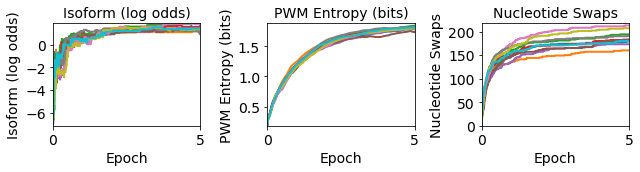

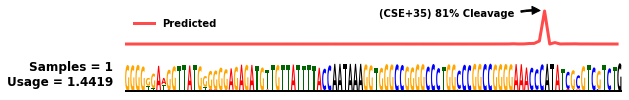

Optimizing objective 7...
Epoch 1/5
500/500 [==============================] - 46s 93ms/step - loss: 20.6693
Epoch 2/5
500/500 [==============================] - 35s 71ms/step - loss: 5.1099
Epoch 3/5
500/500 [==============================] - 42s 84ms/step - loss: 2.7258
Epoch 4/5
500/500 [==============================] - 33s 67ms/step - loss: 1.6662
Epoch 5/5
500/500 [==============================] - 36s 71ms/step - loss: 1.2814


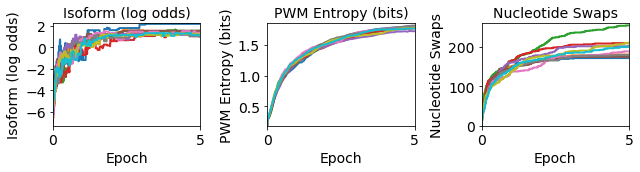

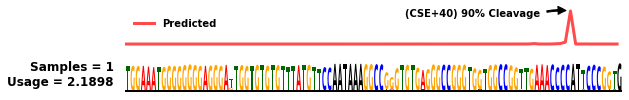

Optimizing objective 8...
Epoch 1/5
500/500 [==============================] - 48s 95ms/step - loss: 32.2674
Epoch 2/5
500/500 [==============================] - 34s 68ms/step - loss: 7.5344
Epoch 3/5
500/500 [==============================] - 37s 74ms/step - loss: 3.9813
Epoch 4/5
500/500 [==============================] - 50s 101ms/step - loss: 3.2143
Epoch 5/5
500/500 [==============================] - 52s 104ms/step - loss: 2.7056


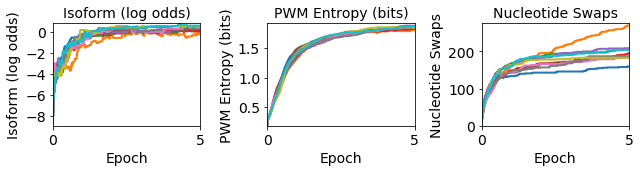

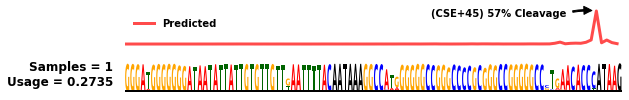

In [11]:
#Run SeqProp Optimization (experiment 'Hardcoded AT')

print("Running optimization experiment 'Hardcoded AT'")

#Number of PWMs to generate per objective
n_sequences = 10
#Number of One-hot sequences to sample from the PWM at each grad step
n_samples = 1
#Number of epochs per objective to optimize
n_epochs = 5#10
#Number of steps (grad updates) per epoch
steps_per_epoch = 500

sequence_templates = [
    seq_template[:cut_pos] + "AT" + seq_template[cut_pos + 2:]
    for cut_pos in cut_objectives
]

losses = [
    get_cleavage_loss(
        cut_pos,
        punish_up_c = True,
        punish_dn_cse = True,
        punish_dn_aruns = False,
        reward_dn_ggcc = False if cut_pos < 105 else True
    ) for cut_pos in cut_objectives
]

hardcoded_at_pwms, hardcoded_at_cuts = run_seqprop(sequence_templates, cut_objectives, losses, n_sequences, n_samples, n_epochs, steps_per_epoch)


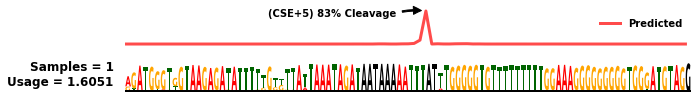

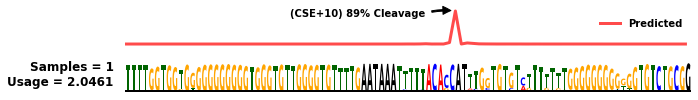

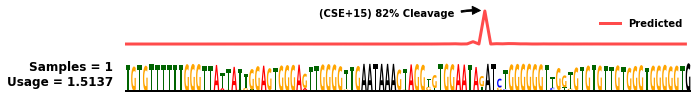

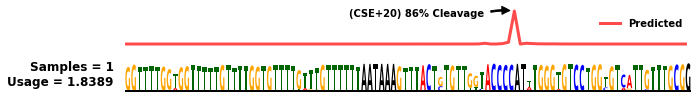

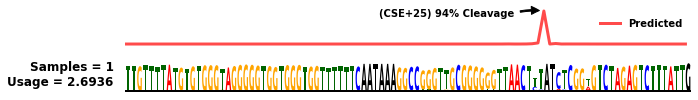

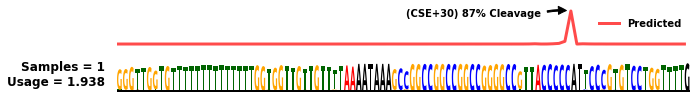

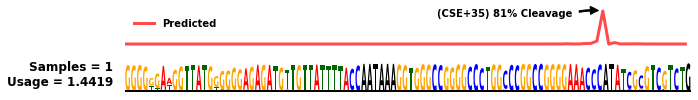

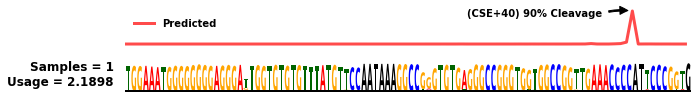

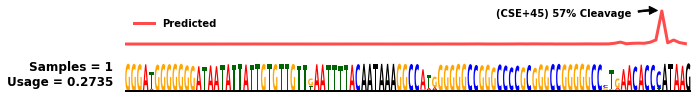

In [12]:
#Plot one PWM sequence logo per optimized objective (Experiment 'Hardcoded AT')

pwms = hardcoded_at_pwms
cuts = hardcoded_at_cuts

pwm_index = 0 #Chosen PWM index
for obj_index, sequence_template in enumerate(sequence_templates) :
    target_cut = cut_objectives[obj_index]
    
    pwm = np.expand_dims(pwms[obj_index][pwm_index, :, :, 0], axis=0)
    cut = np.expand_dims(cuts[obj_index][0, pwm_index, :], axis=0)
    iso = np.expand_dims(np.sum(cut[:, target_cut:target_cut + 1], axis=-1), axis=-1)

    plot_seqprop_logo(pwm, iso, cut, annotate_peaks='max', sequence_template=sequence_template, figsize=(10, 1.5), width_ratios=[1, 8], logo_height=0.8, usage_unit='log', plot_start=70-40, plot_end=76+50)
